# Install required libraries

In [1]:
#%pip install tensorflow
#%pip install spacy
#%pip install tweetnlp
#%pip install matplotlib
#%pip install seaborn

In [ ]:
!python -m spacy download en_core_web_lg

# Introduction

Understanding customer feedback has become pivotal for driving strategic decisions and enhancing customer satisfaction. With the advent of digital platforms, customers frequently express their opinions and experiences online, creating a wealth of data that businesses can leverage to improve their services and products. 

This project focuses on harnessing the power of Natural Language Processing (NLP), a subset of artificial intelligence, to develop a sentiment analysis system that categorizes this feedback.

Sentiment analysis, a critical aspect of NLP, involves interpreting and classifying emotions in textual data. Our system is designed to analyze customer feedback and classify it into three distinct sentiment categories: negative, positive, and neutral. By doing so, it provides a nuanced understanding of customer perceptions and experiences. 

Negative feedback highlights areas needing improvement, positive feedback affirms what the business is doing well, and neutral feedback offers a balanced view that is neither explicitly positive nor negative.

Data: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
- twitter_training.csv
- twitter_validation.csv

# Import required libraries

In [3]:
import pandas as pd
import spacy
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Embedding, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import tweetnlp
from joblib import dump, load

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [4]:
print('Is_GPU_available: ' + str(torch.cuda.is_available()))
if torch.cuda.is_available() == True:
    print('GPU Information: ' + torch.cuda.get_device_name(0))

Is_GPU_available: True
GPU Information: NVIDIA GeForce RTX 3090 Ti


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Preparation

The first part of this project is about starting off with the basics. We first load our data, making sure it's ready for use. Then, we take a quick look at it to understand what's there - checking out what kind of information we have, spotting any obvious patterns or odd things. This step helps us get ready for the more detailed work that comes next.

In [6]:
train_path = 'data\\twitter_training.csv'
val_path = 'data\\twitter_validation.csv'

In [7]:
df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   2401                                                   74681 non-null  int64 
 1   Borderlands                                            74681 non-null  object
 2   Positive                                               74681 non-null  object
 3   im getting on borderlands and i will murder you all ,  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [9]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column                                                                                                                                                                                                                                              Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                                              --------------  ----- 
 0   3364                                                                                                                                                                                                                                                999 non-null    int64 
 1   Facebook                                                                   

Right now, the dataset doesn't have any column names. To make it easier to understand and work with, we're going to add names to each column. This will help us know what each part of the data is about and make analyzing the data simpler.

In [10]:
columns = ['textID','location', 'sentiment', 'text' ]

In [11]:
df_train.columns = columns
df_val.columns = columns

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     74681 non-null  int64 
 1   location   74681 non-null  object
 2   sentiment  74681 non-null  object
 3   text       73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [13]:
df_train.head()

,textID,location,sentiment,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [14]:
df_val.head()

,textID,location,sentiment,text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


Moving forward, we will remove any entries from our dataset that contain null values in either the 'Text' or 'Sentiment' columns.

In [15]:
def remove_null_texts(df,col):
    """
    Remove rows where the 'text' column is null.
    """
    # Displaying the number of null values in the 'text' column
    null_texts_count = df[col].isnull().sum()
    print(f"Number of null values in the {col} column: {null_texts_count}")

    # Dropping rows where the 'text' column is null
    df_cleaned = df.dropna(subset=[col])

    # Displaying the number of rows removed
    print(f"Number of rows removed: {null_texts_count}")

    return df_cleaned

In [16]:
df_train = remove_null_texts(df_train,'text')
df_train = remove_null_texts(df_train,'sentiment')

Number of null values in the text column: 686
Number of rows removed: 686
Number of null values in the sentiment column: 0
Number of rows removed: 0


In [17]:
df_val = remove_null_texts(df_val,'text')
df_val = remove_null_texts(df_val,'sentiment')

Number of null values in the text column: 0
Number of rows removed: 0
Number of null values in the sentiment column: 0
Number of rows removed: 0


In [18]:
print('df_train Shape',df_train.shape)
print('df_val Shape',df_val.shape)

df_train Shape (73995, 4)
df_val Shape (999, 4)


Next, we are going to streamlin the dataset to concentrate on key information. Specifically, we will retain only the **text** and **sentiment** columns. These two columns are important for our analysis needs. The **text** column provides the actual content we want to examine, while the **sentiment** column offers valuable insights into the emotional tone of each text entry.

In [19]:
df_train_small = df_train[['text','sentiment']]
df_val_small = df_val[['text','sentiment']]

In [20]:
df_train_small.head()

,text,sentiment
0,I am coming to the borders and I will kill you...,Positive
1,im getting on borderlands and i will kill you ...,Positive
2,im coming on borderlands and i will murder you...,Positive
3,im getting on borderlands 2 and i will murder ...,Positive
4,im getting into borderlands and i can murder y...,Positive


In [21]:
df_val_small.head()

,text,sentiment
0,BBC News - Amazon boss Jeff Bezos rejects clai...,Neutral
1,@Microsoft Why do I pay for WORD when it funct...,Negative
2,"CSGO matchmaking is so full of closet hacking,...",Negative
3,Now the President is slapping Americans in the...,Neutral
4,Hi @EAHelp I’ve had Madeleine McCann in my cel...,Negative


We will merge these datasets for combined processing.

In [22]:
train_index = 'train'
validation_index = 'validation'
df = pd.concat([df_train_small.assign(ind=train_index),df_val_small.assign(ind=validation_index)])

In [23]:
df['text'] = df['text'].str.lower()

In [24]:
df.shape

(74994, 3)

In [25]:
df.head()

,text,sentiment,ind
0,i am coming to the borders and i will kill you...,Positive,train
1,im getting on borderlands and i will kill you ...,Positive,train
2,im coming on borderlands and i will murder you...,Positive,train
3,im getting on borderlands 2 and i will murder ...,Positive,train
4,im getting into borderlands and i can murder y...,Positive,train


Now, let's analyze the data to gain deeper insights.

In [26]:
def countplot_sentiment_distribution(df,col):
    """
    Plot the distribution of sentiments in the dataframe.
    """
    # Setting the aesthetic style of the plots
    sns.set_style("whitegrid")

    # Creating the plot
    plt.figure(figsize=(7, 5))
    sns.countplot(data=df, x=col, palette='viridis')

    # Adding titles and labels
    plt.title(f"{col} Distribution", fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Displaying the plot
    plt.show()

In [27]:
def histplot_text_length_distribution(data):
    plt.figure(figsize=(8, 6))
    sns.histplot(data['text'].str.len(), bins=30, kde=False)
    plt.title('Text Length Distribution')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.show()

In [28]:
def pie_sentiment_distribution1(data):
    sentiment_counts = data['sentiment'].value_counts()
    plt.figure(figsize=(6, 6))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Sentiment Distribution')
    plt.show()

In [29]:
def plot_average_text_length_by_sentiment(data):
    data['text_length'] = data['text'].str.len()
    average_length_by_sentiment = data.groupby('sentiment')['text_length'].mean()
    plt.figure(figsize=(8, 6))
    average_length_by_sentiment.plot(kind='bar', color=['blue', 'green', 'red'])
    plt.title('Average Text Length by Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Average Text Length')
    plt.xticks(rotation=0)
    plt.show()

In [30]:
def boxplot_length_distribution(df):
    """
    Plot the distribution of tweet lengths by sentiment with enhanced Y-axis granularity.

    Parameters:
    df (pandas.DataFrame): DataFrame containing 'text' and 'sentiment' columns.
    """
    # Calculate tweet lengths
    df['text_length'] = df['text'].apply(len)

    # Initialize the matplotlib figure
    plt.figure(figsize=(10, 6))

    # Create a boxplot
    sns.boxplot(x='sentiment', y='text_length', data=df, showfliers=True, showmeans=True)

    plt.title('Distribution of Tweet Lengths by Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Length of text')

    # Enhancing Y-axis granularity
    max_length = df['text_length'].max()
    plt.yticks(range(0, max_length + 1, 25))  # Adjust the step (50 in this case) as needed

    # Show the plot
    plt.show()


In [31]:
def filter_and_convert_sentiments(df, sentiment_mapping):
    """
    Filters a DataFrame to keep only specified sentiments and converts those sentiment labels to numerical values.

    Parameters:
    - df: DataFrame containing the Twitter data with a 'Sentiment' column.
    - sentiment_mapping: Dictionary with sentiment text as keys and their numeric representation as values.

    Returns:
    - df: Processed DataFrame with sentiments converted to their corresponding numerical values.
    """

    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df_filtered = df[df['sentiment'].isin(sentiment_mapping.keys())].copy()

    # Convert sentiment labels to their corresponding numerical values using the sentiment_mapping
    df_filtered['sentiment'] = df_filtered['sentiment'].map(sentiment_mapping)

    return df_filtered

C:\Users\Baba\AppData\Local\Temp\ipykernel_4616\2543616231.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='viridis')


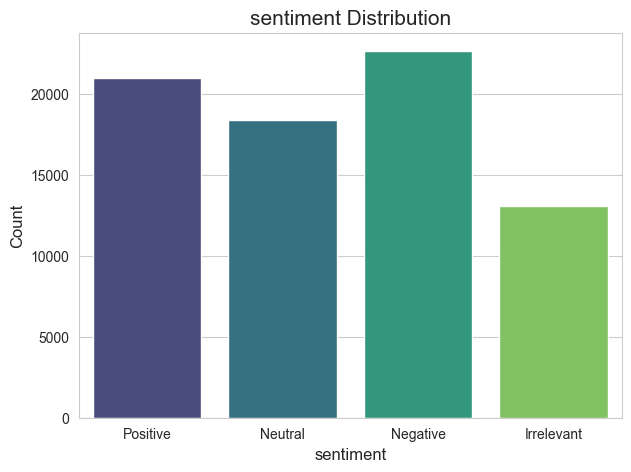

In [32]:
countplot_sentiment_distribution(df,'sentiment')

The sentiment distribution analysis reveals that the 'Sentiment' field has the following classes:

- Negative
- Positive
- Neutral
- Irrelevant

We will remove Irrlevant data. Also, to optimize the performance of our predictive model, we will transform the categorical sentiment labels into numerical values.

In [33]:
sentiment_mapping = {
    'Positive': 0,
    'Negative': 1,
    'Neutral':2
}
df['sentiment_text']=df['sentiment']
df = filter_and_convert_sentiments(df, sentiment_mapping)

In [34]:
df.head()

,text,sentiment,ind,sentiment_text
0,i am coming to the borders and i will kill you...,0,train,Positive
1,im getting on borderlands and i will kill you ...,0,train,Positive
2,im coming on borderlands and i will murder you...,0,train,Positive
3,im getting on borderlands 2 and i will murder ...,0,train,Positive
4,im getting into borderlands and i can murder y...,0,train,Positive


C:\Users\Baba\AppData\Local\Temp\ipykernel_4616\2543616231.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='viridis')


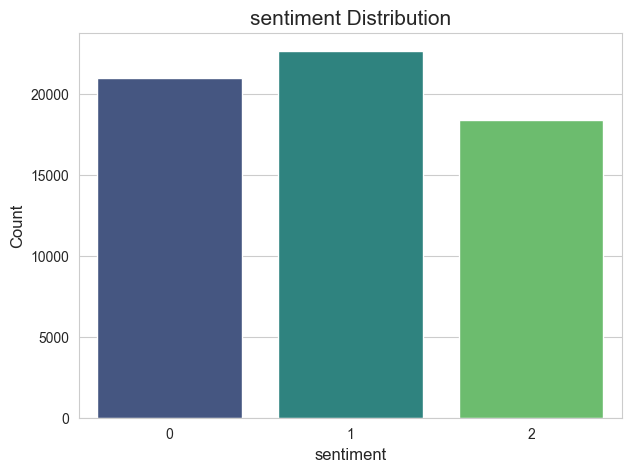

In [35]:
countplot_sentiment_distribution(df,'sentiment')

The classes are balanced

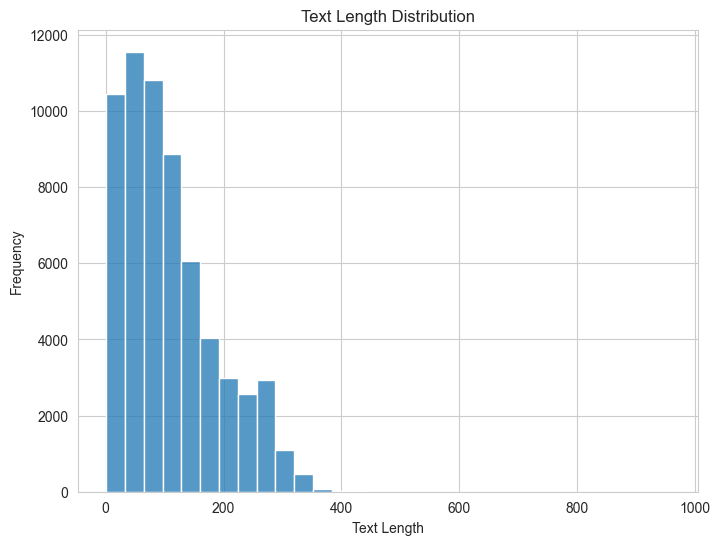

In [36]:
histplot_text_length_distribution(df)

The graph appears to have a right-skewed distribution. This suggests that most of the texts are on the shorter side, with fewer texts having a longer length.

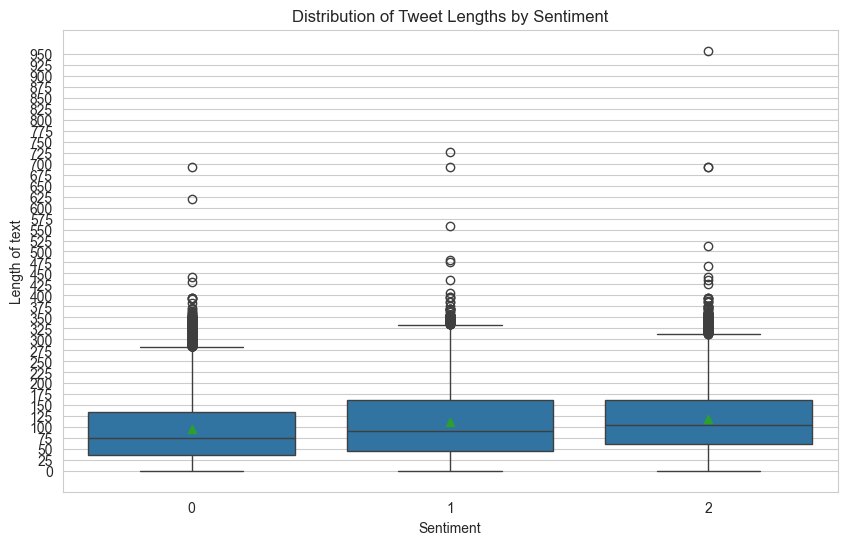

In [37]:
df.text=df.text.astype(str)
boxplot_length_distribution(df)

The graph indicates the presence of numerous outliers characterized by longer text lengths. It appears that these outliers begin at a text length of around 260. To further investigate, we will examine how many entries in the database have a text length exceeding 260 characters.

In [38]:
def count_long_texts(df, threshold=260):
    """
    Count the number of texts longer than a specified threshold and calculate their percentage.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the 'text' column.
    threshold (int): Length threshold for considering a text as 'long'.

    Returns:
    None: Prints the count and percentage of long texts.
    """
    # Count the number of texts longer than the threshold
    long_texts_count = df[df['text'].str.len() > threshold].shape[0]

    # Calculate the percentage of long texts
    total_texts = df.shape[0]
    long_texts_percentage = (long_texts_count / total_texts) * 100

    # Print the results
    print(f"Number of texts longer than {threshold} characters: {long_texts_count}")
    print(f"Percentage of texts longer than {threshold} characters: {long_texts_percentage:.2f}%")


In [39]:
count_long_texts(df)

Number of texts longer than 260 characters: 4038
Percentage of texts longer than 260 characters: 6.52%


The texts exceeding 260 characters constitute 6.52% of our dataset. To enhance model performance, we've decided to exclude them. Retaining these longer texts previously resulted in extensive computation times and suboptimal performance.

In [40]:
# Remove texts longer than 260
df = df[df['text_length']<= 260]


In [41]:
count_long_texts(df)

Number of texts longer than 260 characters: 0
Percentage of texts longer than 260 characters: 0.00%


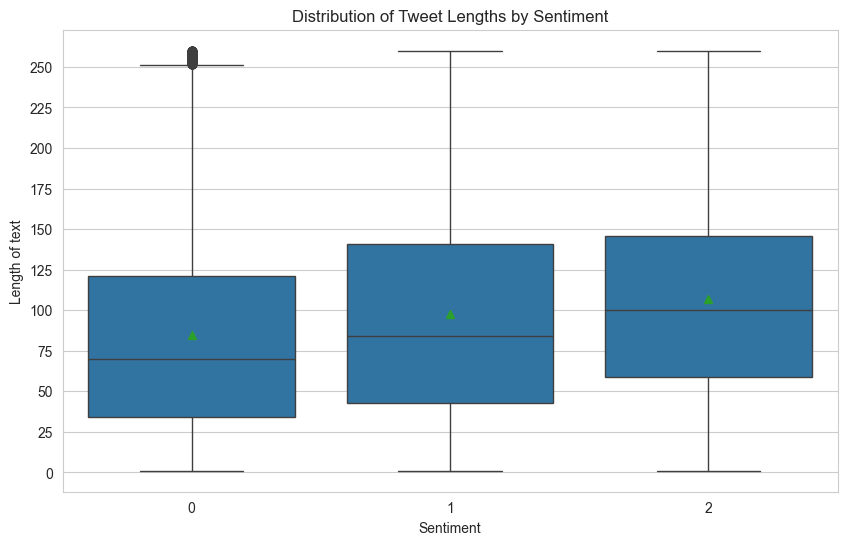

In [42]:
boxplot_length_distribution(df)

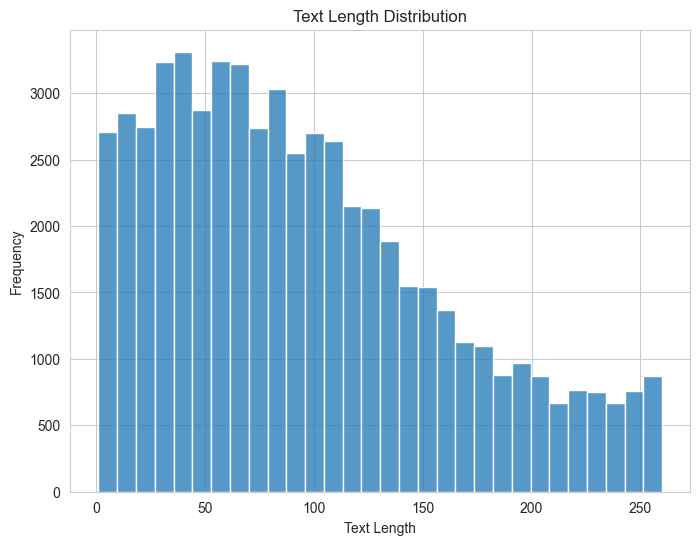

In [43]:
histplot_text_length_distribution(df)

We will remove outliers in an effort to create a more uniform dataset, potentially enhancing the model's predictive accuracy. While we recognize that outliers can often provide useful insights, our previous attempts to use all records did not yield satisfactory performance. We are now exploring different approaches to improve the results

In [44]:
def remove_outliers(df, column_name, iqr_multiplier=3):
    """
    Remove outliers from a dataframe based on the Interquartile Range (IQR) method.

    Parameters:
    df (pandas.DataFrame): The dataframe from which to remove outliers.
    column_name (str): The name of the column based on which outliers will be identified.
    iqr_multiplier (float): The multiplier for the IQR to define the bounds for outliers.

    Returns:
    pandas.DataFrame: A new dataframe with outliers removed.
    """
    # Calculate the IQR
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define the bounds for outliers
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR

    # Filter the dataframe to remove outliers
    filtered_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    return filtered_df

In [45]:
df.shape

(57910, 5)

In [46]:
df = remove_outliers(df, 'text_length',iqr_multiplier=1)

In [47]:
df.shape

(55278, 5)

In [48]:
print("Number of rows removed:", 57910-55278)

Number of rows removed: 2632


We will check the dataset for any texts that are less than 2 characters long, and remove them. These short texts usually aren't helpful for our work.

In [49]:
df = df.sort_values(by='text_length')

In [50]:
df.head(10)

,text,sentiment,ind,sentiment_text,text_length
72365,,1,train,Negative,1
62242,a,1,train,Negative,1
43679,,1,train,Negative,1
8687,,1,train,Negative,1
34288,i,2,train,Neutral,1
43961,,1,train,Negative,1
68848,a,0,train,Positive,1
8873,,2,train,Neutral,1
62021,,2,train,Neutral,1
44212,a,0,train,Positive,1


In [51]:
# Remove texts less than 3
df = df[df['text_length'] > 2]

In [52]:
df.head(10)

,text,sentiment,ind,sentiment_text,text_length
32620,the,1,train,Negative,3
32644,can,2,train,Neutral,3
4522,and,1,train,Negative,3
24382,was,0,train,Positive,3
67042,you,0,train,Positive,3
2413,...,1,train,Negative,3
66368,wtf,1,train,Negative,3
26434,not,0,train,Positive,3
2986,...,2,train,Neutral,3
34336,out,0,train,Positive,3


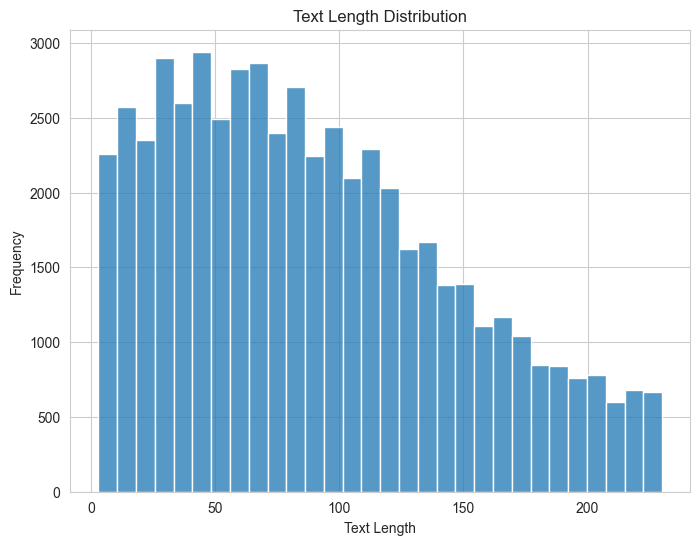

In [53]:
histplot_text_length_distribution(df)

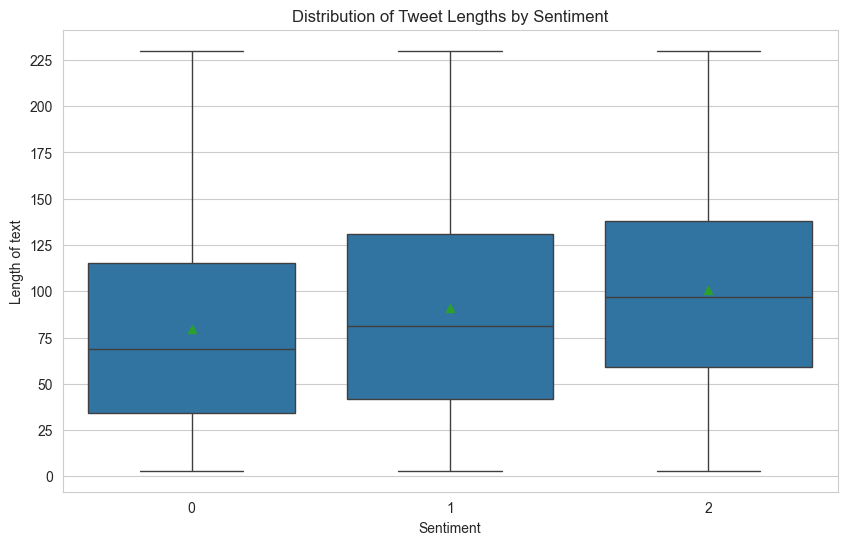

In [54]:
boxplot_length_distribution(df)

In [55]:
df.shape

(54558, 5)

In [56]:
def count_short_text_words(df, max_length=4):
    """
    Get all records with text length of max_length or less, count each word, and return the results.

    Parameters:
    df (pandas.DataFrame): The DataFrame with a 'text' column.
    max_length (int): The maximum length of text to consider.

    Returns:
    pandas.DataFrame: A DataFrame with word counts.
    """
    # Filter to get texts of length max_length or less
    short_texts = df[df['text'].str.len() <= max_length]

    # Split the texts into words and count the occurrences
    word_counts = short_texts['text'].str.split(expand=True).stack().value_counts()

    # Convert the Series to a DataFrame
    word_counts_df = word_counts.reset_index()
    word_counts_df.columns = ['Word', 'Count']

    # Print the word counts
    print(word_counts_df)

    return word_counts_df

In [57]:
result_df = count_short_text_words(df)

     Word  Count
0     the     77
1     wow     71
2     you     70
3     wtf     37
4    wow.     33
..    ...    ...
117  was.      1
118    me      1
119  stop      1
120  ls!!      1
121  aha.      1

[122 rows x 2 columns]


In [58]:
# Remove duplicates based on the 'text' column
df = df.drop_duplicates(subset='text', keep='first')

Check the dataset to identify and remove short texts with one word of 3, 4, or 5 length, retaining only those that may be beneficial for training purposes.

In [59]:
def filter_by_length(df,n):
    return df[df['text'].str.len() == n]

In [60]:
df_filtered_3 = filter_by_length(df,3)
df_filtered_4 = filter_by_length(df,4)
df_filtered_5 = filter_by_length(df,5)

Save them to files to check them one by one.

In [61]:
df_filtered_3.to_csv('text_length_3.csv', index=False)
df_filtered_4.to_csv('text_length_4.csv', index=False)
df_filtered_5.to_csv('text_length_5.csv', index=False)

In [62]:
# List of words to keep
words_to_keep = ["wow", "sad", "wtf", "rip","damn","nice","fuck","Booo","awful","trash","toxic","good","smart","fine","sweet","error","fraud","why??","fail.","nice.","good"]

In [63]:
condition = ~((df['text'].str.len() == 3) & (~df['text'].isin(words_to_keep)))
df_filtered = df[condition]

In [64]:
condition = ~((df_filtered['text'].str.len() == 4) & (~df_filtered['text'].isin(words_to_keep)))
df_filtered = df_filtered[condition]

In [65]:
condition = ~((df_filtered['text'].str.len() == 5) & (~df_filtered['text'].isin(words_to_keep)))
df_filtered = df_filtered[condition]

In [66]:
#df_filtered[df_filtered['text'].str.len() == 3]
filter_by_length(df_filtered,3)

,text,sentiment,ind,sentiment_text,text_length
66368,wtf,1,train,Negative,3
26552,wow,0,train,Positive,3
16223,sad,1,train,Negative,3
16529,rip,1,train,Negative,3


In [67]:
filter_by_length(df_filtered,4)

,text,sentiment,ind,sentiment_text,text_length
22490,nice,0,train,Positive,4
18002,damn,1,train,Negative,4
13439,fuck,1,train,Negative,4


In [68]:
filter_by_length(df_filtered,5)

,text,sentiment,ind,sentiment_text,text_length
66559,awful,1,train,Negative,5
12692,trash,1,train,Negative,5
15203,toxic,1,train,Negative,5
54206,smart,0,train,Positive,5
992,sweet,0,train,Positive,5
5521,error,1,train,Negative,5
50400,fraud,1,train,Negative,5
41749,fail.,1,train,Negative,5
1981,nice.,0,train,Positive,5
49028,why??,1,train,Negative,5


In [69]:
df = df_filtered

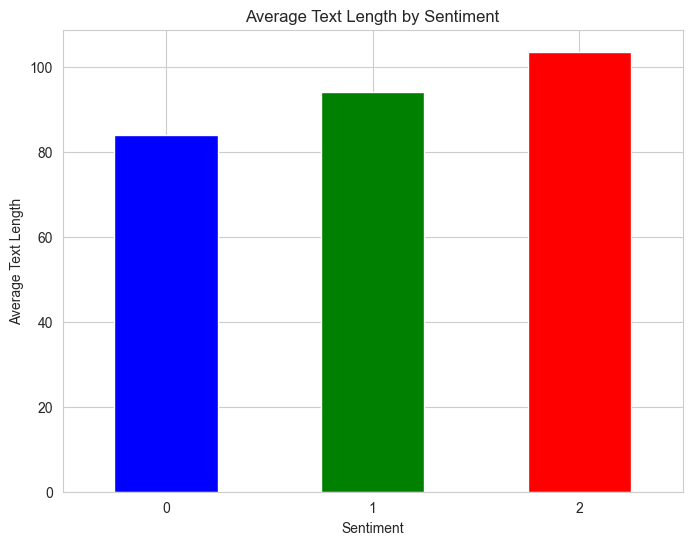

In [70]:
plot_average_text_length_by_sentiment(df)

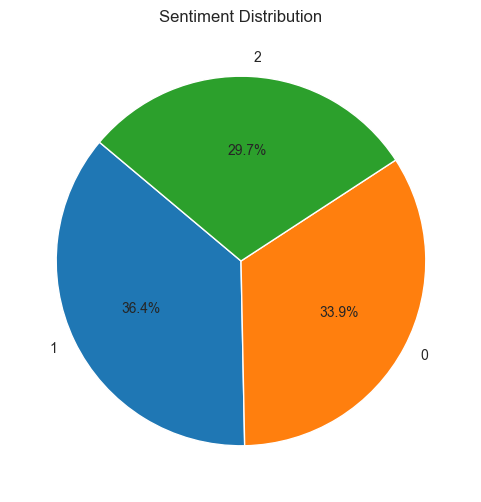

In [71]:
pie_sentiment_distribution1(df)

The classes are still balanced, removing the outliers did not affect them

In [72]:
df.tail(10)

,text,sentiment,ind,sentiment_text,text_length
47729,"hug it out, let the strong survive, the weak p...",0,train,Positive,230
6914,if there is anyone out there who has found and...,2,train,Neutral,230
64873,congrats to joke! finally consolidating that i...,0,train,Positive,230
45733,if you haven't used your cell phone for the la...,1,train,Negative,230
70657,"@ ghostrecon @ ubisoft your game is broken, so...",1,train,Negative,230
37159,"perhaps i am not the first to see this, but ma...",2,train,Neutral,230
24132,@ irina _ vukolova...... last night we saw oth...,0,train,Positive,230
6274,@nyxjacob thanks for entering grand<unk>.. rev...,2,train,Neutral,230
44756,"tricia b., a recruiter at verizon, are proud o...",2,train,Neutral,230
53295,org i just realised red dead redemption turned...,0,train,Positive,230


In [73]:
df.head(10)

,text,sentiment,ind,sentiment_text,text_length
66368,wtf,1,train,Negative,3
26552,wow,0,train,Positive,3
16223,sad,1,train,Negative,3
16529,rip,1,train,Negative,3
22490,nice,0,train,Positive,4
18002,damn,1,train,Negative,4
13439,fuck,1,train,Negative,4
66559,awful,1,train,Negative,5
12692,trash,1,train,Negative,5
15203,toxic,1,train,Negative,5


## Data Preprocessing
We need to standardize and simplify the text data, which is crucial for effective natural language processing (NLP). The following steps need to be done:

- Tokenizing: Breaks down text into individual words or tokens, making it easier for the model to process and learn from the text data.

- Converting to Lowercase: Ensures consistency by treating words like "Hello" and "hello" as the same word, avoiding duplication in the model's v- ocabulary.

- Removing Stop Words: Eliminates common words (e.g., "the", "is", "in") that usually don't contribute to the sentiment of the text, allowing the model to focus on more meaningful words.

- Lemmatizing: Reduces words to their base or root form, which helps in consolidating different forms of the same word, so they are analyzed as a single item.

Together, these preprocessing steps clean and refine the text data, leading to better model performance by focusing on the most relevant features of the text.

In [74]:
nlp = spacy.load('en_core_web_lg')

In [75]:
# Lemmatizes words and removes stop words.
def lemmatize_and_remove_stopwords(text):
    return " ".join([token.lemma_ for token in nlp(text) if not token.is_stop])

# Converts text to lowercase.
def to_lowercase(text):
    return text.lower()

# Removes special characters from the text.
def remove_special_characters(text):
    # Keeping alphabets, numbers, basic punctuation, and whitespace
    return re.sub('[^\w\s,.!?;:\']', '', text)

def remove_stopwords(text):
    """
    Remove stopwords from a text.

    Parameters:
    text (str): Text to remove stopwords from.

    Returns:
    str: Text without stopwords.
    """
    return " ".join([token for token in text.split() if token not in nlp.Defaults.stop_words])

def lemmatize_texts(texts):
    """
    Lemmatize a batch of texts.

    Parameters:
    texts (list): A list of texts to lemmatize.

    Returns:
    list: A list of lemmatized texts.
    """
    return [" ".join([token.lemma_ for token in doc]) for doc in nlp.pipe(texts)]

def preprocess_data(df, col, methods):
    """
    Preprocesses the input text by applying a list of specified methods dynamically.

    Parameters:
    - df: A pandas DataFrame containing the text data.
    - col: The name of the column in the DataFrame that contains the text.
    - methods: A list of strings where each string is a method to apply on the text.

    Returns:
    - The DataFrame with the preprocessed text.
    """
    for method_name in methods:
        if method_name in globals():
            df[col] = df[col].apply(globals()[method_name])
        else:
            raise ValueError(f"The method {method_name} is not defined.")
    return df

In [76]:
# Applying the preprocessing function to the dataframe
col = 'text'
methods_to_apply = ['to_lowercase', 'remove_special_characters', 'lemmatize_and_remove_stopwords']
df = preprocess_data(df, col, methods_to_apply)
df = df[df['text'] != '.']
df['text'] = df['text'].str.strip()

C:\Users\Baba\AppData\Local\Temp\ipykernel_4616\2245740796.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].str.strip()


In [77]:
df.head(10)

,text,sentiment,ind,sentiment_text,text_length
66368,wtf,1,train,Negative,3
26552,wow,0,train,Positive,3
16223,sad,1,train,Negative,3
16529,rip,1,train,Negative,3
22490,nice,0,train,Positive,4
18002,damn,1,train,Negative,4
13439,fuck,1,train,Negative,4
66559,awful,1,train,Negative,5
12692,trash,1,train,Negative,5
15203,toxic,1,train,Negative,5


In [78]:
df.tail(10)

,text,sentiment,ind,sentiment_text,text_length
47729,"hug , let strong survive , weak perish sound c...",0,train,Positive,230
6914,"find purchase book , feel able rate thenor rev...",2,train,Neutral,230
64873,congrat joke ! finally consolidate 100 year sk...,0,train,Positive,230
45733,"cell phone couple hour , american carriers ver...",1,train,Negative,230
70657,"ghostrecon ubisoft game break , frame lean c...",1,train,Negative,230
37159,", macos _ _ developer make internet work decad...",2,train,Neutral,230
24132,"irina _ vukolova ...... night see place kiev ,...",0,train,Positive,230
6274,nyxjacob thank enter grandunk .. review video ...,2,train,Neutral,230
44756,"tricia b. , recruiter verizon , proud voluntee...",2,train,Neutral,230
53295,org realise red dead redemption turn 10 year ....,0,train,Positive,230


In [79]:
# save the dataset for later use
df.to_csv('df.csv',index=False)

## Model Building

### LSTM
Long Short-Term Memory (LSTM) networks are particularly suited for semantic analysis due to their ability to process and make predictions based on long sequences of data. Unlike traditional neural networks, LSTMs have a unique structure that allows them to retain information over long periods, making them ideal for understanding context and the meaning of words in longer text passages.

#### Tokenization and Padding
Tokenize and pad sequences to prepare text data for the model. We need to perform the following two key operations on the text data:

- Tokenization: It processes the text by converting each word into a unique integer based on its frequency in the dataset, while only considering the top max_features most frequent words. This step is essential for preparing the text for numerical processing by machine learning algorithms.

- Padding: After tokenization, it ensures that all sequences (now lists of integers) have the same length by adding zeros to shorter sequences. This uniformity is crucial for batch processing in neural networks, as they require inputs of a consistent size.

In [80]:
max_features = 3000
# Initializing the tokenizer with a specific number of tokens to consider based on word frequency
tokenizer = Tokenizer(num_words=max_features, split=' ')

In [81]:
 # Fitting the tokenizer on the text data
tokenizer.fit_on_texts(df[col].values)

In [82]:
def get_top_words_dataframe(tokenizer, top_n=10):
    """
    Create a DataFrame containing the top `n` words, their indices, and frequencies from the tokenizer.

    Parameters:
    - tokenizer: The fitted Keras Tokenizer object.
    - top_n: The number of top words to include in the DataFrame.

    Returns:
    - A DataFrame with the top words, their indices, and frequencies.
    """
    # Ensure top_n is a positive integer
    if top_n < 1:
        raise ValueError("top_n must be a positive integer.")

    # Get word counts and indices
    word_counts = tokenizer.word_counts
    word_index = tokenizer.word_index

    # Sort words by frequency in descending order
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

    # Slice the top `n` words
    top_words = sorted_words[:top_n]

    # Create lists to populate the DataFrame
    words = []
    indices = []
    frequencies = []

    # Populate the lists with word data
    for word, count in top_words:
        words.append(word)
        indices.append(word_index[word])
        frequencies.append(count)

    # Create the DataFrame
    df_top_words = pd.DataFrame({
        'Word': words,
        'Index': indices,
        'Frequency': frequencies
    })

    return df_top_words

In [83]:
n =20
top_words_df = get_top_words_dataframe(tokenizer, top_n=n)
top_words_df.head(n)

,Word,Index,Frequency
0,game,1,6670
1,play,2,4379
2,good,3,3755
3,com,4,3121
4,like,5,3002
5,pic,6,2852
6,2,7,2716
7,twitter,8,2659
8,get,9,2581
9,love,10,2305


Splits the features (X) and labels (Y) into train and test subsets.

In [84]:
# Split the data into training and validation sets
df_train, df_val = train_test_split(df, test_size=0.2)

In [85]:
print('train Shape:',df_train.shape)
print('validation Shape:',df_val.shape)

train Shape: (40617, 5)
validation Shape: (10155, 5)


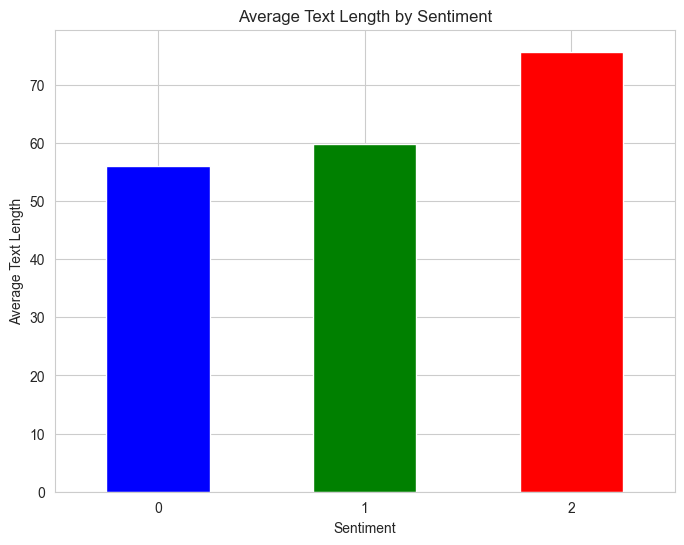

In [86]:
plot_average_text_length_by_sentiment(df_train)

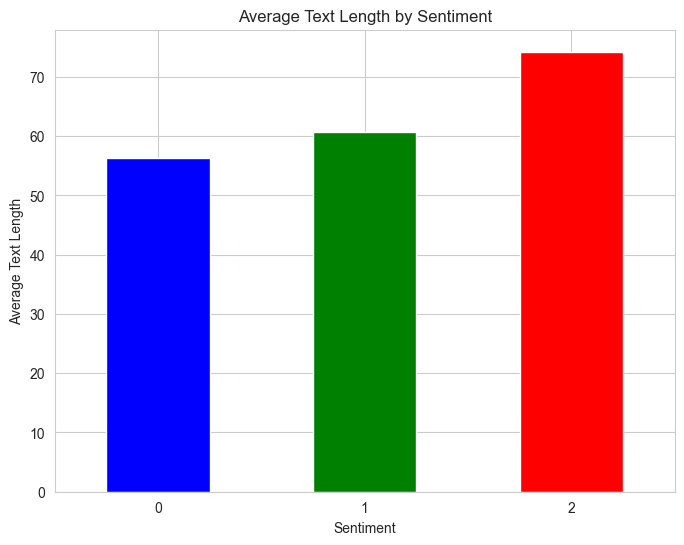

In [87]:
plot_average_text_length_by_sentiment(df_val)

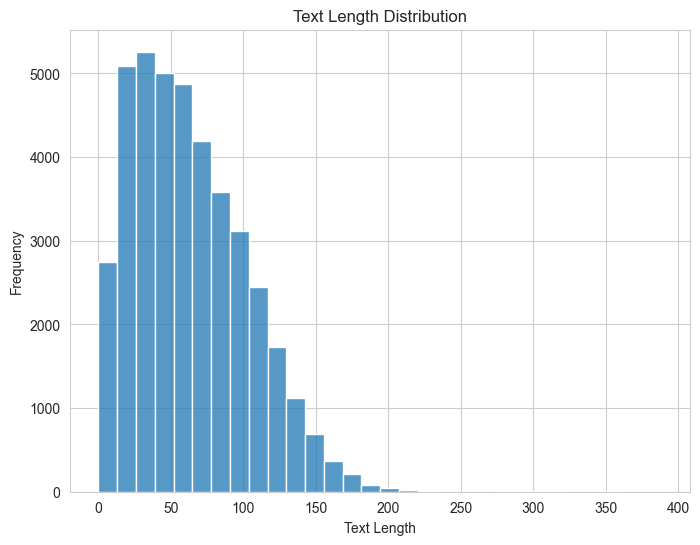

In [88]:
histplot_text_length_distribution(df_train)

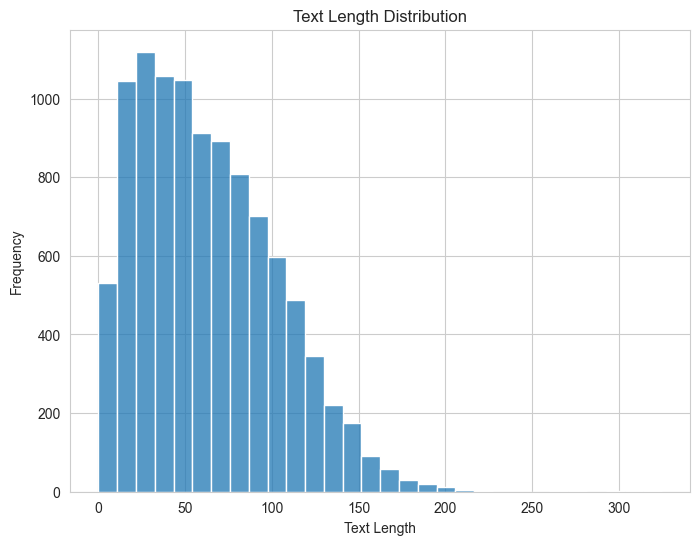

In [89]:
histplot_text_length_distribution(df_val)

In [90]:
def pad(tokenizer,df, col):
    """
    This function takes as input a dataframe and a column name.
    It pads the text data in the specified column of the dataframe.

    Parameters:
    - df: pandas DataFrame containing the text data.
    - col: string, the name of the column in the dataframe containing the text data.

    Returns:
    - X: numpy array, containing the tokenized and padded text data.
    """

    # Transforming the text data to sequences of integers
    X = tokenizer.texts_to_sequences(df[col].values)

    # Padding the sequences to ensure consistent length
    X = pad_sequences(X)

    return X

In [91]:
X_train = pad(tokenizer,df_train, 'text')
X_val = pad(tokenizer,df_val, 'text')

In [92]:
[X_train.shape,X_val.shape]

[(40617, 39), (10155, 32)]

In [93]:
def pad_seq(seq_to_pad, reference_seq, pad_type='pre', constant_value=0):
    """
    Pad sequences to have the same number of features as the reference sequence.

    Parameters:
    - seq_to_pad: NumPy array of sequences that need padding.
    - reference_seq: NumPy array of the reference sequence to match the time steps.
    - pad_type: String, either 'pre' or 'post', indicating where to add padding. Defaults to 'pre'.
    - constant_value: Value to use for padding. Defaults to 0.

    Returns:
    - Padded NumPy array of sequences.
    """
    # Calculate the number of features in the reference sequences
    time_steps_reference = reference_seq.shape[1]

    # Calculate the padding required to match the reference sequence
    padding = time_steps_reference - seq_to_pad.shape[1]

    if padding < 0:
        raise ValueError("The sequence to pad has more features than the reference sequence.")

    # Determine padding configuration
    if pad_type == 'pre':
        pad_width = ((0, 0), (padding, 0))
    elif pad_type == 'post':
        pad_width = ((0, 0), (0, padding))
    else:
        raise ValueError("pad_type must be 'pre' or 'post'.")

    # Apply padding to the sequence
    seq_padded = np.pad(
        seq_to_pad,
        pad_width,
        'constant',
        constant_values=(constant_value)
    )

    return seq_padded

In [94]:
X_val = pad_seq(X_val, X_train, pad_type='pre', constant_value=0)

In [95]:
[X_train.shape,X_val.shape]

[(40617, 39), (10155, 39)]

In [96]:
def one_hot_encode_labels(df, column_name):
    """
    Convert categorical column values into a one-hot encoded NumPy array.

    Parameters:
    - df: pandas DataFrame containing the data.
    - column_name: string, the name of the column to be one-hot encoded.

    Returns:
    - A NumPy array containing the one-hot encoded labels.

    Summary:
    The function takes a DataFrame and the column name which contains categorical values.
    It uses the pandas `get_dummies` method to perform one-hot encoding and then converts
    the result into a NumPy array which is suitable for use as labels in many machine learning frameworks.

    Comments:
    One-hot encoding is a process where categorical variables are converted into a form that
    could be provided to ML algorithms to do a better job in prediction. Each unique category value
    is transformed into a binary vector with one high (1) and all the rests low (0).
    """
    # Check if the specified column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"The column '{column_name}' does not exist in the DataFrame.")

    # Perform one-hot encoding using pandas get_dummies
    one_hot_encoded_df = pd.get_dummies(df[column_name])

    # Convert the resulting DataFrame into a NumPy array
    one_hot_encoded_array = np.array(one_hot_encoded_df)

    return one_hot_encoded_array

In [97]:
Y_train = one_hot_encode_labels(df_train, 'sentiment')
Y_val = one_hot_encode_labels(df_val, 'sentiment')

In [98]:
print('X train Shape:',X_train.shape)
print('X validation Shape:',X_val.shape)
print('Y train Shape:',Y_train.shape)
print('Y train Shape:',Y_val.shape)

X train Shape: (40617, 39)
X validation Shape: (10155, 39)
Y train Shape: (40617, 3)
Y train Shape: (10155, 3)


#### LSTM Model Building

In [99]:
def build_model(
        input_length, 
        max_features=3000, 
        embed_dim=128, 
        lstm_out=256):
    
    loss= 'categorical_crossentropy'
    activation='softmax'
    optimizer='adam'
    met=[
                'accuracy',
                metrics.Precision(),
                metrics.Recall(),
                metrics.AUC()
            ]
    
    model = Sequential()

    # Embedding layer for vectorizing text
    model.add(Embedding(max_features, embed_dim, input_length=input_length))

    # Dropout layer after embedding to reduce overfitting on feature level
    model.add(SpatialDropout1D(0.3))

    # First LSTM layer with dropout for sequence processing, returns sequences
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))

    # Dropout layer after LSTM to reduce overfitting on sequence level
    model.add(Dropout(0.5))
    
    # Second LSTM layer without return_sequences
    model.add(LSTM(lstm_out // 2, dropout=0.5, recurrent_dropout=0.5))

    # Dense layer for output prediction with softmax activation for multi-class classification
    model.add(Dense(3, activation=activation))

    # Compiling the model with categorical cross-entropy loss and additional metrics
    model.compile(
        loss=loss, 
        optimizer=optimizer, 
        metrics=met
    )

    print(model.summary())

    return model

In [100]:
model = build_model(X_train.shape[1])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 39, 128)           384000    
                                                                 
 spatial_dropout1d (Spatial  (None, 39, 128)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 39, 256)           394240    
                                                                 
 dropout (Dropout)           (None, 39, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                      

#### LSTM Model Training

In [101]:
def train_model(model, X_train, Y_train, epochs=100, batch_size=32,validation_split=0.2):
    """
    Train the LSTM model.
    """
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='accuracy',
        patience=5,  # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    )

    # Reduce learning rate when a metric has stopped improving
    reduce_lr = ReduceLROnPlateau(
        monitor='accuracy',
        factor=0.2,  # Factor by which the learning rate will be reduced
        patience=3,  # Number of epochs with no improvement after which learning rate will be reduced
        min_lr=1e-6  # Lower bound on the learning rate
    )

    history = model.fit(
        X_train, Y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        shuffle=False,
        callbacks=[early_stopping,reduce_lr])

    return history

In [102]:
history  = train_model(model, X_train, Y_train)

Epoch 1/100


1270/1270 - 124s - loss: 0.7697 - accuracy: 0.6653 - precision: 0.7459 - recall: 0.5495 - auc: 0.8373 - lr: 0.0010 - 124s/epoch - 98ms/step
Epoch 2/100
1270/1270 - 119s - loss: 0.5946 - accuracy: 0.7611 - precision: 0.7975 - recall: 0.7149 - auc: 0.9054 - lr: 0.0010 - 119s/epoch - 94ms/step
Epoch 3/100
1270/1270 - 121s - loss: 0.5104 - accuracy: 0.8004 - precision: 0.8319 - recall: 0.7647 - auc: 0.9305 - lr: 0.0010 - 121s/epoch - 95ms/step
Epoch 4/100
1270/1270 - 121s - loss: 0.4496 - accuracy: 0.8241 - precision: 0.8532 - recall: 0.7943 - auc: 0.9461 - lr: 0.0010 - 121s/epoch - 95ms/step
Epoch 5/100
1270/1270 - 121s - loss: 0.4020 - accuracy: 0.8435 - precision: 0.8701 - recall: 0.8180 - auc: 0.9568 - lr: 0.0010 - 121s/epoch - 96ms/step
Epoch 6/100
1270/1270 - 121s - loss: 0.3636 - accuracy: 0.8585 - precision: 0.8836 - recall: 0.8364 - auc: 0.9646 - lr: 0.0010 - 121s/epoch - 95ms/step
Epoch 7/100
1270/1270 - 121s - loss: 0.3304 - accuracy: 0.8733 - precision: 0.8959 - r

In [103]:
# Save the model
dump(model, 'models\\LSTM_model.joblib')

['models\\LSTM_model.joblib']

#### LSTM Model Evaluating

In [104]:
history_dict = history.history

In [105]:
# Print the last value of each metric
print("Final Accuracy:", history_dict['accuracy'][-1])
print("Final Loss:", history_dict['loss'][-1])
print("Final Precision:", history_dict['precision'][-1])
print("Final Recall:", history_dict['recall'][-1])
print("Final AUC:", history_dict['auc'][-1])

Final Accuracy: 0.9694709181785583
Final Loss: 0.07081370055675507
Final Precision: 0.9808728694915771
Final Recall: 0.9633404612541199
Final AUC: 0.998466968536377


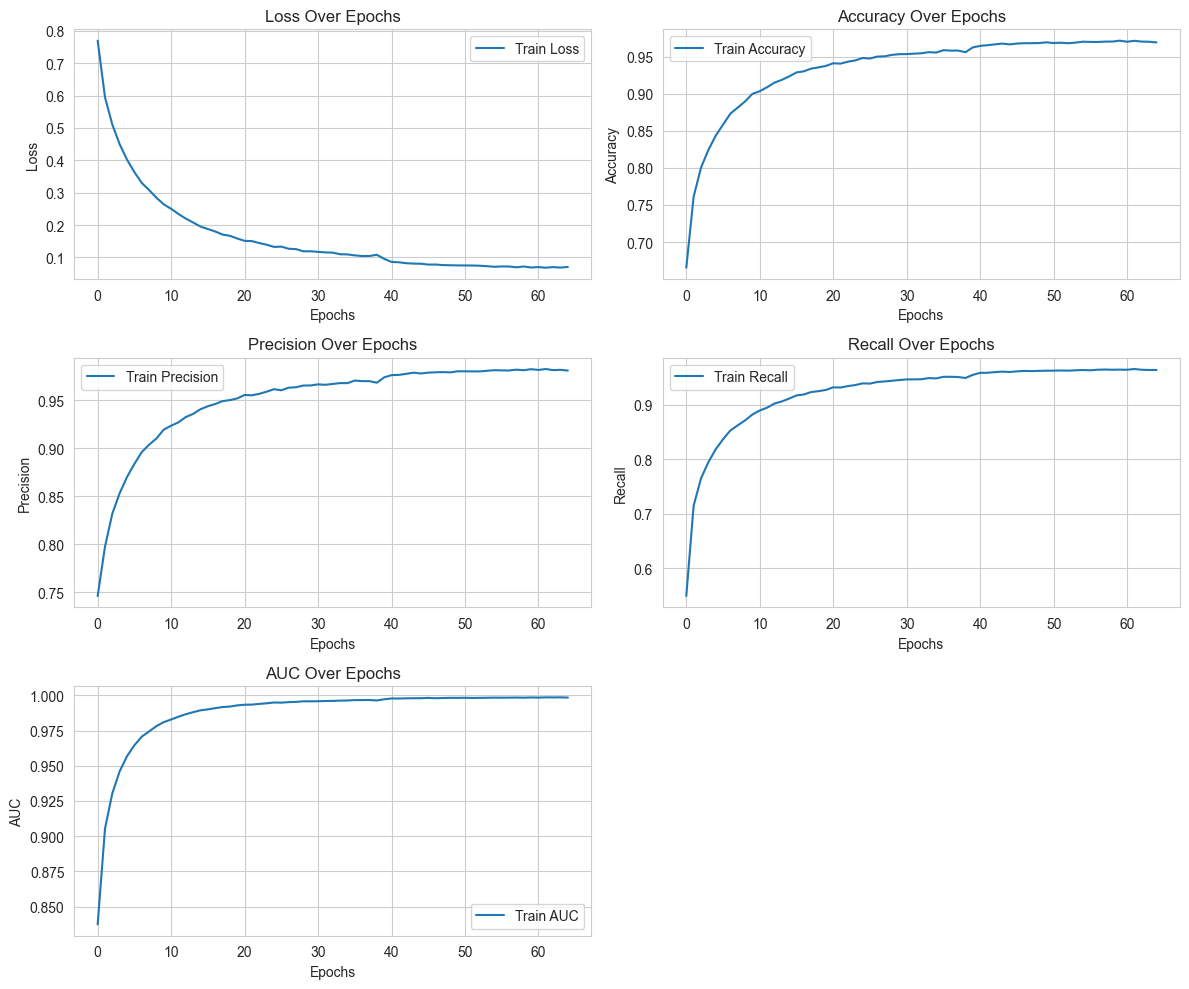

<Figure size 640x480 with 0 Axes>

In [106]:
plt.figure(figsize=(12, 10))

# Plot the loss
plt.subplot(3, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(3, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3, 2, 3)
plt.plot(history.history['precision'], label='Train Precision')
plt.title('Precision Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3, 2, 4)
plt.plot(history.history['recall'], label='Train Recall')
plt.title('Recall Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3, 2, 5)
plt.plot(history.history['auc'], label='Train AUC')
plt.title('AUC Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

In [107]:
def predict_classes(model, X):
    """
    Predict classes for each sample in X using the provided model.

    Parameters:
    - model: The trained Keras model.
    - X: The input data for making predictions.

    Returns:
    - A list of predicted class indices.
    """
    return [np.argmax(model.predict(x.reshape(1, -1), batch_size=1, verbose=0)) for x in X]

In [108]:
def calculate_accuracy(y_true, y_pred):
    """
    Calculate the accuracy of predictions.

    Parameters:
    - y_true: The true labels.
    - y_pred: The predicted labels.

    Returns:
    - The accuracy as a float.
    """
    correct_predictions = np.sum(y_true == y_pred)
    return correct_predictions / len(y_true)

In [109]:
def plot_confusion_matrix(y_true, y_pred):
    """
    Plot a confusion matrix of the true and predicted labels.

    Parameters:
    - y_true: The true labels.
    - y_pred: The predicted labels.
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='GnBu')
    plt.title("Confusion Matrix")
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()

In [110]:
def evaluate_model(model, X_test, Y_test):
    """
    Evaluate the LSTM model on the test data.

    Summary:
    This function predicts classes using the LSTM model for each sample in the test set,
    calculates the accuracy, and plots the confusion matrix.

    Parameters:
    - model: The trained LSTM model.
    - X_test: Test features.
    - Y_test: True labels for the test set.
    """
    # Make predictions
    y_pred = predict_classes(model, X_test)
    y_true = np.argmax(Y_test, axis=1)

    # Calculate accuracy
    accuracy = calculate_accuracy(y_true, y_pred)
    print(f"Accuracy: {accuracy*100:.2f}%")

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred)

    return y_pred,y_true

Accuracy: 88.68%


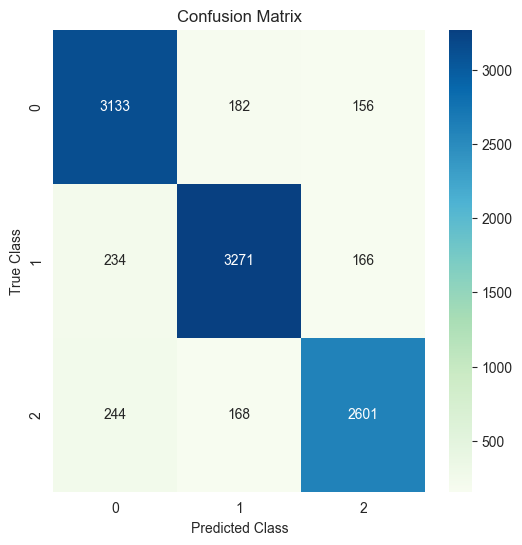

In [111]:
y_pred,y_true = evaluate_model(model, X_val, Y_val)

In [112]:
# Save the model
dump(model, 'LSTM_model.joblib')

['LSTM_model.joblib']

In [113]:
# Load the model later
loaded_model = load('LSTM_model.joblib')

### TweetNLP

TweetNLP for all the NLP enthusiasts working on Twitter and social media in general! The python library tweetnlp provides a collection of useful tools to analyze/understand tweets such as sentiment analysis, emoji prediction, and named-entity recognition, powered by state-of-the-art language modeling specialized on social media.

https://github.com/cardiffnlp/tweetnlp

In [ ]:
tweet_model = tweetnlp.load_model('sentiment') 

In [115]:
#Using Example
print('Using TweetNLP for Sentiment Analysis')
print('I\'m happy. is:',tweet_model.sentiment('I\'m happy.'))
print('I\'m sad. is:',tweet_model.sentiment('I\'m sad.'))

Using TweetNLP for Sentiment Analysis
I'm happy. is: {'label': 'positive'}
I'm sad. is: {'label': 'negative'}


In [116]:
# Define a function that will convert sentiment labels to numeric values
def get_sentiment_numeric(label):
    if label == 'positive':
        return 0
    elif label == 'negative':
        return 1
    else:
        return 2  # for neutral or any other class

In [117]:
# Define a function to apply the model to each row and get the numeric sentiment
def predict_sentiment(text):
    result = tweet_model.sentiment(text)
    return get_sentiment_numeric(result['label'])

In [118]:
# Apply the predict_sentiment function to the 'text' column and create the 'y_prd' column
df_val['y_prd'] = df_val['text'].apply(predict_sentiment)

In [119]:
df_val[['text','sentiment_text','sentiment','y_prd']]

,text,sentiment_text,sentiment,y_prd
21642,thank ! ! ! ! go to buy cs gun fnatic sticker,Positive,0,0
2957,music play little snippet black op cold war ca...,Positive,0,0
17597,exactly .,Neutral,2,2
68694,shit go sideways .. twitch.tv sa7azar .,Neutral,2,1
7056,good duo support watch playstation 4 !,Neutral,2,0
...,...,...,...,...
48262,like promote free pack water outside supermarket,Positive,0,2
50282,castro1021 12k free point day good .,Positive,0,0
39106,playhearthstone,Positive,0,2
28371,videogamedeal good pretty sweet deal right go ...,Neutral,2,0


In [120]:
# Convert the 'sentiment' and 'y_prd' columns to lists
y_true = df_val['sentiment'].tolist()
y_pred = df_val['y_prd'].tolist()

In [121]:
def calculate_accuracy(y_true, y_pred):
    """
    Calculate the accuracy of predictions.

    Parameters:
    - y_true: The true labels.
    - y_pred: The predicted labels.

    Returns:
    - The accuracy as a float.
    """
    correct_predictions = np.sum(y_true == y_pred)
    return correct_predictions / len(y_true)

In [122]:
accuracy = calculate_accuracy(np.array(y_true), np.array(y_pred))

In [123]:
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.58


 The accuracy is quite low, only 59%.

### BERT

#### BERT (distilbert-base-uncased)
We will try to use BERT  for semantic analysis. In this approach, we will keep all layers of BERT unchanged (freeze them) to preserve their pre-trained state. Then, we will use the output from BERT's last hidden layer as input. This output contains rich, context-aware representations of the input text, benefiting from BERT's deep understanding of language context and nuances. Finally, we will pass this output through a linear neural network layer (nn.Linear) for the classification task. This method is advantageous because it leverages BERT's advanced language processing capabilities for feature extraction while allowing for customization in the final classification stage, tailored to the specific requirements of the semantic analysis task

In [124]:
import torch
from torch import nn
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

In [ ]:
# Load tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [126]:
# Freeze DistilBERT weights
for param in distilbert.parameters():
    param.requires_grad = False

In [127]:
# Custom classifier layer
class SentimentClassifier(nn.Module):
    def __init__(self, distilbert, num_labels):
        super().__init__()
        self.distilbert = distilbert
        self.classifier = nn.Linear(self.distilbert.config.dim, num_labels)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state
        pooled_output = hidden_state[:, 0]
        return self.classifier(pooled_output)

In [128]:
# Define a Dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, add_special_tokens=True, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.long)
        }

In [129]:
# Create an instance of the model
num_labels = 3
model = SentimentClassifier(distilbert, num_labels)

In [130]:
train_texts = df_train['text'].tolist()
train_labels = df_train['sentiment'].tolist()

In [131]:
dataset = SentimentDataset(train_texts, train_labels, tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [132]:
# Move model to device
model.to(device)

SentimentClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1

In [133]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [ ]:
for epoch in range(3):  # Example: 3 epochs
    index = 1
    model.train()
    for batch in dataloader:
        print(f'{epoch}-{index}')
        index = index+1
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

print("Training complete")

In [135]:
# Set model to evaluation mode
model.eval()

SentimentClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1

In [136]:
# Extract texts and labels from df_val
val_texts = df_val['text'].tolist()
val_labels = df_val['sentiment'].tolist()

# Create a Dataset instance for df_val
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)

# Create the DataLoader for df_val
df_val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [137]:
# Initialize lists to store predictions and actual labels
predictions = []
actuals = []

In [138]:
# Disable gradient calculations
with torch.no_grad():
    for batch in df_val_dataloader: 
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        # Convert outputs to predictions
        pred = torch.argmax(outputs, dim=1)
        
        predictions.extend(pred.tolist())
        actuals.extend(labels.tolist())

In [139]:
accuracy = accuracy_score(actuals, predictions)

In [140]:
# Calculate metrics
precision, recall, f1, _ = precision_recall_fscore_support(actuals, predictions, average='weighted')

In [141]:
# Print results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.5779419005416051
Precision: 0.5737133630280142
Recall: 0.5779419005416051
F1-Score: 0.5725777801162211


<font color='red'>The result was unexpectedly disappointing. We had anticipated better performance due to the use of pre-trained BERT, but unfortunately, we encountered a significantly low accuracy percentage</font>

#### BERT (roberta-base)

RoBERTa-base" is an advanced version of the BERT model for natural language processing. It's designed to understand and analyze human language more accurately. RoBERTa has been trained on a larger dataset and for a longer time than the original BERT, leading to improved performance in understanding text.

We plan to fine-tune it to see if this improves our understanding of semantic analysis.

In [142]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer,RobertaForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW
from tqdm import tqdm 

In [143]:
# Initialize the RoBERTA tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [144]:
# Tokenize the dataset
def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=128)

In [145]:
# Tokenize the dataset
tokenized_data = tokenize_function(df['text'].tolist())

In [146]:
# Extract input_ids and attention_mask from tokenized data
input_ids = tokenized_data['input_ids']
attention_mask = tokenized_data['attention_mask']

In [147]:
# Prepare the labels (sentiments)
labels = df['sentiment'].tolist()

In [148]:
# Split the input_ids, attention_mask, and labels
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.2, random_state=42)
train_masks, val_masks, _, _ = train_test_split(attention_mask, labels, test_size=0.2, random_state=42)

In [149]:
# Load a pre-trained RoBERTA model for sequence classification
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)  # 3 for three-class classification

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [150]:
# Convert the data to PyTorch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(val_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(val_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(val_masks)

In [151]:
# Create TensorDatasets
train_data = TensorDataset(train_inputs, train_masks, train_labels)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)

In [152]:
# Create DataLoaders
batch_size = 16 

train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size)

In [153]:
# Use AdamW optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
epochs = 10 

c:\API Projects\NLP\.venv\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [154]:
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [155]:
# Lists to keep track of metrics
training_loss_history = []
training_accuracy_history = []
validation_loss_history = []
validation_accuracy_history = []

The training data is divided into batches. For each batch, the data is moved to the specified device (like a CPU or GPU), which is used for computation. The batch contains input IDs, input masks, and labels. Input IDs and masks are used by the model to understand the data, and labels are the correct answers for the training data.

In [156]:
# Initialize history lists
training_loss_history = []
training_accuracy_history = []

# Start training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    train_correct = 0
    total_train_examples = 0

    for batch_idx, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        predictions = torch.argmax(probabilities, dim=-1)

        train_correct += (predictions == b_labels).sum().item()
        total_train_examples += b_labels.size(0)

    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = train_correct / total_train_examples

    # Save training metrics
    training_loss_history.append(avg_train_loss)
    training_accuracy_history.append(train_accuracy)

    print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_train_loss}, Accuracy: {train_accuracy}")


Epoch 1/10 - Loss: 0.7326601408113875, Accuracy: 0.6916808233005884
Epoch 2/10 - Loss: 0.47821568567988065, Accuracy: 0.8147819878376049
Epoch 3/10 - Loss: 0.29309027083071376, Accuracy: 0.8912031907821848
Epoch 4/10 - Loss: 0.1905202293189337, Accuracy: 0.9303001206391412
Epoch 5/10 - Loss: 0.14054180304939826, Accuracy: 0.9498485855676194
Epoch 6/10 - Loss: 0.11143133463709409, Accuracy: 0.9607061082797843
Epoch 7/10 - Loss: 0.0903129002776805, Accuracy: 0.9675505330280424
Epoch 8/10 - Loss: 0.07913077954995101, Accuracy: 0.9716374916906714
Epoch 9/10 - Loss: 0.06922834930298542, Accuracy: 0.974911982667356
Epoch 10/10 - Loss: 0.06393959723758615, Accuracy: 0.9770539429303001


Across the 10 epochs, there is a clear improvement in the model's performance. This is indicated by the decreasing loss and increasing accuracy with each epoch.

In [157]:
# Print the metrics for the epoch
print(f"Epoch {epoch + 1}/{epochs}")
print(f"Average training loss: {avg_train_loss:.4f}")
print(f"Training accuracy: {train_accuracy:.4f}")

Epoch 10/10
Average training loss: 0.0639
Training accuracy: 0.9771


In [158]:
dump(model, 'models\\BERT_model.joblib')

['models\\BERT_model.joblib']

In [159]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
eval_loss = 0
eval_accuracy = 0
total_eval_examples = 0
all_predictions = []
all_labels = []

for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

    eval_loss += loss.item()
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    predictions = torch.argmax(probabilities, dim=-1)

    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(b_labels.cpu().numpy())

    eval_accuracy += (predictions == b_labels).sum().item()
    total_eval_examples += b_labels.size(0)

avg_val_loss = eval_loss / len(validation_dataloader)
avg_val_accuracy = eval_accuracy / total_eval_examples

# Append to history for plotting if needed
validation_loss_history.append(avg_val_loss)
validation_accuracy_history.append(avg_val_accuracy)


In [160]:
# Print the metrics for the epoch
print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy}")

Validation Loss: 0.3035773499014945, Validation Accuracy: 0.9329394387001477


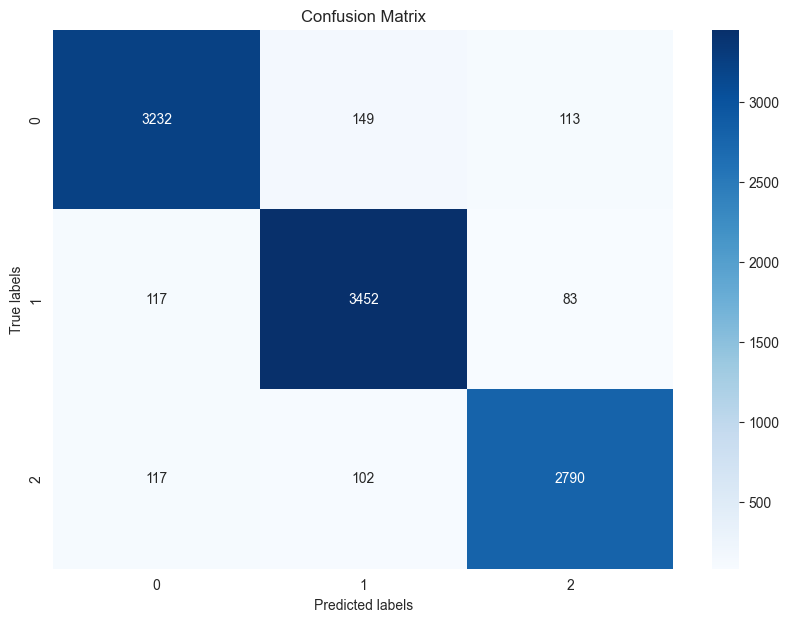

In [161]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Summary:

- Training Performance:
    - By the end of the 10th epoch, the training phase showed significant improvement.
    - The average training loss, a measure of how far the model's predictions were from the actual results, was quite low at 0.0639. This indicates that the model was making accurate predictions most of the time.
    - The training accuracy, which shows how often the model was correct, was very high at 97.71%. This means the model was able to correctly predict the outcome for most of the training data.

- Validation Performance:
    - The validation loss was 0.3036, which is higher than the training loss. This suggests that the model didn't perform as well on the validation set (new, unseen data) as it did on the training set.
    - The validation accuracy was 93.29%. While this is slightly lower than the training accuracy, it still indicates a high level of accuracy and suggests that the model generalizes well to new data.